In [1]:
import os
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pathlib import Path

In [7]:
from shapely.geometry import LineString, Point

print(os.listdir(Path.cwd() / ".." / "resources" / "pypsa-fes" / "networks"))
n = pypsa.Network(Path.cwd() / ".." / "resources" / "pypsa-fes" / "networks" / "elec_s_eso_ec.nc")
# n = pypsa.Network(Path.cwd() / ".." / "resources" / "pypsa-fes" / "networks" / "elec_s_ec_lv1.5__bev-heat-ss_LW_2023.nc")
# n = pypsa.Network(Path.cwd() / ".." / "resources" / "pypsa-fes" / "networks" / "elec_s_ec_lv1.5__bev-heat-ss_LW_2050.nc")

file = Path.cwd() / ".." / "data" / "interconnectors_pypsa_gb_future.csv"
import geopandas as gpd

shapes = gpd.read_file(Path.cwd() / ".." / "resources" / "pypsa-fes" / "regions_onshore_elec_s_eso.geojson")

n = pypsa.Network(Path.cwd() / ".." / "resources" / "pypsa-fes" / "networks" / "elec_s_eso_ec.nc")

def adjust_interconnectors(n, file, year):

    links = pd.read_csv(file, index_col=0, encoding = "ISO-8859-1")
    links["installed date"] = pd.to_datetime(links["installed date"])

    existing_links = n.links.loc[
        (n.links.carrier == "DC") &
        ((n.links.bus0.str.contains("GB")) | 
        (n.links.bus1.str.contains("GB")))
        ]

    n.links.drop(existing_links.index, inplace=True)

    onhold_links = links.loc[links["on hold"].fillna(False)].index
    links.drop(onhold_links, inplace=True)

    print(f"Not adding interconnectors on hold: {', '.join(onhold_links)}")

    start_state = pd.Timestamp(year=year, month=1, day=1)

    future_links = links.loc[links["installed date"] > start_state].index
    links.drop(future_links, inplace=True)

    print(f"Not adding interconnectors of future years: {', '.join(future_links)}")

    bus0 = gpd.GeoDataFrame(geometry=gpd.points_from_xy(links["bus0 lon"], links["bus0 lat"]), crs="EPSG:4326", index=links.index)
    bus1 = gpd.GeoDataFrame(geometry=gpd.points_from_xy(links["bus1 lon"], links["bus1 lat"]), crs="EPSG:4326", index=links.index)

    bus0 = gpd.sjoin(bus0, shapes, how="left")
    bus1 = gpd.sjoin(bus1, shapes, how="left")

    links = pd.concat((
        links[["bus1 lon", "bus1 lat", "p_nom", "bus0 lon", "bus0 lat"]],
        bus0["name"].rename("bus0"),
        bus1["name"].rename("bus1"),
    ), axis=1)

    drop_links = links.loc[links["bus0"].isna() | links["bus1"].isna()].index
    print(f"Links {', '.join(drop_links)} have no bus0 or bus1 and are dropped.")

    links.drop(drop_links, inplace=True)
    print(f"Adding links to network: {', '.join(links.index)}")

    links["geometry"] = links.apply(
        lambda row: LineString([Point(row["bus0 lon"], row["bus0 lat"]), Point(row["bus1 lon"], row["bus1 lat"])]),
        axis=1
    )

    n.madd(
        "Link",
        links.index,
        bus0=links["bus0"],
        bus1=links["bus1"],
        p_nom=links["p_nom"],
        p_min_pu=-1,
        geometry=links["geometry"],
        carrier="DC",
    )


adjust_interconnectors(n, file, 2040)

['base.nc', 'elec.nc', 'elec_s.nc', 'elec_s_ec_lv1.5__bev-heat-ss_LW_2050.nc', 'elec_s_eso.nc', 'elec_s_eso_ec.nc']


INFO:pypsa.io:Imported network elec_s_eso_ec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_eso_ec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
Index(['Shetland HVDC Connection'], dtype='object', name='name')


Index(['14814', '14826', '5581', '5580', '8009', '14815', '8708', '14804+1'], dtype='object', name='Link')
Index(['bus0', 'bus1', 'length', 'underground', 'under_construction', 'tags',
       'geometry', 'carrier', 'p_min_pu', 'p_nom', 'underwater_fraction',
       'capital_cost', 'efficiency', 'p_nom_extendable', 'type', 'build_year',
       'lifetime', 'p_nom_min', 'p_nom_max', 'p_set', 'p_max_pu',
       'marginal_cost', 'marginal_cost_quadratic', 'stand_by_cost',
       'terrain_factor', 'committable', 'start_up_cost', 'shut_down_cost',
       'min_up_time', 'min_down_time', 'up_time_before', 'down_time_before',
       'ramp_limit_up', 'ramp_limit_down', 'ramp_limit_start_up',
       'ramp_limit_shut_down', 'p_nom_opt'],
      dtype='object')
(8, 37)
Not adding interconnectors on hold: NorthConnect
start_date  2040-01-01 00:00:00
Not adding interconnectors of future years: 
Links Xlinks have no bus0 or bus1 and are dropped.
Adding links to network: BritNed, EastWest, Moyle, Nemo, I

In [15]:
n = pypsa.Network(Path.cwd() / ".." / "resources" / "pypsa-fes" / "networks" / "elec_s_ec_lv1.5__bev-heat-ss_LW_2050.nc")

n.links.loc[n.links.carrier == "DC"]

Index(['Shetland HVDC Connection'], dtype='object', name='name')
INFO:pypsa.io:Imported network elec_s_ec_lv1.5__bev-heat-ss_LW_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


,bus0,bus1,length,underground,under_construction,tags,geometry,carrier,p_min_pu,p_nom,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
14801,DE1 0,BE1 0,419.631990,0.0,1.0,,"LINESTRING(6.43068069229957 50.8136946409214,6...",DC,-1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
14805,DK2 0,DK1 0,205.403041,1.0,0.0,,"LINESTRING(11.2853515176222 55.5308076825323,1...",DC,-1.0,600.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
14824,DK2 0,DE1 0,671.236037,0.0,0.0,,"LINESTRING(11.9669051857726 55.421747727341,12...",DC,-1.0,600.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
5601,SE2 0,DE1 0,1521.144169,0.0,0.0,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""32550"", ""...","LINESTRING(12.9299984288384 55.0630403498842,1...",DC,-1.0,600.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
14803,NL1 0,DK1 0,604.737909,0.0,1.0,,"LINESTRING(6.75668661933496 53.437616158174,6....",DC,-1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
14821,NL1 0,NO2 0,1221.169700,0.0,0.0,,"LINESTRING(6.83036734046461 53.4374933986115,6...",DC,-1.0,700.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
14848,DE1 0,NO2 0,1392.290011,0.0,1.0,,"LINESTRING(6.81690675921544 58.6338502746805,6...",DC,-1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
14819,SE2 0,DK1 0,872.789817,0.0,0.0,,"LINESTRING(10.2163282994747 57.1311139024238,1...",DC,-1.0,250.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
14809,SE2 0,DK1 0,872.789817,0.0,0.0,,"LINESTRING(10.2163571716117 57.1310010356663,1...",DC,-1.0,300.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


hhh


In [43]:
def adjust_interconnectors(n, year):

    intercons = Path.cwd() / ".." / "data" / "interconnectors_pypsa_gb.csv"
    intercons_future = Path.cwd() / ".." / "data" / "interconnectors_pypsa_gb_future.csv"

    intercons = pd.read_csv(intercons) 
    intercons_future = pd.read_csv(intercons_future)
    intercons_future["installed date"] = pd.to_datetime(intercons_future["installed date"])

    print(intercons.sort_values(by="p_nom", ascending=False))
    print("--------------------")
    print(intercons_future.sort_values(by="p_nom", ascending=False)[["p_nom", "installed date", "bus0", "bus1"]])

    print("--------------------")
    links = n.links.loc[n.links.carrier == "DC"]
    # gb intercons
    print(links[["p_nom", "bus0", "bus1"]])
    links = links.loc[links.bus0.str.contains("GB") ^ links.bus1.str.contains("GB")]
    print(links.shape)
    
    print(links.sort_values(by="p_nom", ascending=False)[["p_nom", "bus0", "bus1"]])



n.links.loc[n.links.carrier == "DC"]

adjust_interconnectors(n, 2023)

       name         bus0       bus1 carrier  p_nom
4       IFA      France1  Sellindge      DC   2100
0   BritNed  Netherlands    Kemsley      DC   1100
3      Nemo      Belgium  Sellindge      DC   1100
5      IFA2      France2   Lovedean      DC   1100
1  EastWest      Ireland    Deeside      DC    600
2     Moyle   N. Ireland   Neilston      DC    600
--------------------
    p_nom installed date         bus0          bus1
4    2000     2020-01-01      France1     Sellindge
6    1400     2021-01-01       Norway   Stella West
8    1400     2023-01-01      Denmark       Walpole
10   1400     2024-01-01      France1       Kemsley
11   1400     2024-01-01      Germany       Kemsley
12   1400     2025-01-01       Norway     Peterhead
13   1400     2025-01-01      France2  S.W.Penisula
0    1000     2020-01-01  Netherlands       Kemsley
3    1000     2020-01-01      Belgium     Sellindge
5    1000     2020-01-01      France2      Lovedean
7    1000     2022-01-01      France1     Sellindg

In [61]:
import geopandas as gpd

shapes = gpd.read_file(Path.cwd().parent / "data" / "pypsa-gb_shape" / "zones_json.geojson")

<AxesSubplot:>

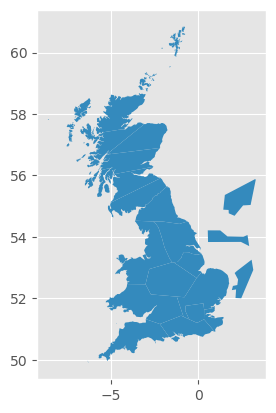

In [63]:
# for poly in :
# for p in poly:
shapes.plot()

In [64]:
shapes

,Name_1,geometry
0,Z7,"POLYGON ((-1.77918 55.64501, -1.76863 55.64191..."
1,Z6,"POLYGON ((-2.14293 55.91612, -2.13801 55.91462..."
2,Z5,"POLYGON ((-2.57681 56.28075, -2.57681 56.27778..."
3,Z3,"MULTIPOLYGON (((-5.00939 55.72932, -5.01618 55..."
4,Z2,"POLYGON ((-3.09422 57.67233, -3.07868 57.66942..."
5,Z1_4,"MULTIPOLYGON (((-6.16002 56.46955, -6.21247 56..."
6,Z1_2,"MULTIPOLYGON (((-7.38199 56.98753, -7.37352 56..."
7,Z1_3,"MULTIPOLYGON (((-3.34789 58.65204, -3.34057 58..."
8,Z1_1,"MULTIPOLYGON (((-1.60814 59.54735, -1.61042 59..."
9,Z4,"MULTIPOLYGON (((-5.11779 55.43976, -5.16356 55..."
